In [1]:
#@title Import Required Libraries
import re
from gensim.models import KeyedVectors
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset , Dataset
import random
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from torch.nn.utils.rnn import pad_sequence , pack_padded_sequence, pad_packed_sequence


nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
def device_use():
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    return device

device = device_use()
print(f'Using device: {device}')

Using device: cuda


In [3]:
def preprocess_text(text):
    """
    Preprocess the text by:
    - Tokenizing sentences
    - Removing special characters and digits
    - Converting to lowercase
    """
    sentences = sent_tokenize(text)
    cleaned_sentences = []
    for sentence in sentences:
        sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)
        sentence = sentence.lower()
        words = word_tokenize(sentence)
        if words:
            cleaned_sentences.append(words)

    return cleaned_sentences

def load_data(file_path):
    """
    Loads text from a file and returns the cleaned sentences.
    """
    with open(file_path, 'r') as f:
        text = f.read()  # Read the entire text
    return preprocess_text(text)

# Load and preprocess the data
file_path = '/kaggle/input/training/Auguste_Maquet.txt'
sentences = load_data(file_path)


In [4]:
def build_vocab(sentences, glove_dictionary):
    vocab = {'<UNK>': 0 ,'<PAD>':1}
    for sent in sentences:
        for word in sent:
            if word in glove_dictionary:
                if word not in vocab:
                    vocab[word] = len(vocab)
    return vocab

In [5]:
glove_dict = {}
with open('/kaggle/input/gloves/glove.6B.300d.txt', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        word_embedding = [float(x) for x in values[1:]]
        glove_dict[word] = word_embedding

In [6]:
random.shuffle(sentences)
train_split = int(0.7 * len(sentences))
test_split = int(0.9 * len(sentences))

train_sentences = sentences[:train_split]
test_sentences = sentences[train_split:test_split]
val_sentences = sentences[test_split:]

print(f"Train sentences: {len(train_sentences)}")
print(f"Test sentences: {len(test_sentences)}")
print(f"Validation sentences: {len(val_sentences)}")


Train sentences: 24785
Test sentences: 7082
Validation sentences: 3541


In [7]:
vocab = build_vocab(train_sentences, glove_dict)

In [8]:
index_to_word = {index: word for word, index in vocab.items()}
index = 204
word = index_to_word.get(index, '<UNK>')
print(f"The word with index {index} is '{word}'")

The word with index 204 is 'aim'


In [9]:
embedding_matrix = [glove_dict[word] if word in glove_dict else [0]*300 for word in vocab]


In [10]:
class TextDataset(Dataset):
    def __init__(self, sentences, vocab, embedding_matrix):
        self.sentences = sentences
        self.vocab = vocab
        self.embedding_matrix = embedding_matrix

        # Filter out empty sequences and sequences with zero length
        self.data = self.create_sequences()

    def create_sequences(self):
        sequences = []
        for sent in self.sentences:
            if len(sent) > 1:  # Ensure the sentence has more than one word
                input_seq = [self.vocab.get(word, self.vocab['<UNK>']) for word in sent[:-1]]
                output_seq = [self.vocab.get(word, self.vocab['<UNK>']) for word in sent[1:]]
                if len(input_seq) > 0 and len(output_seq) > 0:  # Check if sequences are non-empty
                    sequences.append((input_seq, output_seq))
        return sequences

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_seq, output_seq = self.data[idx]
        input_embeds = torch.tensor(input_seq, dtype=torch.long)
        output_seq = torch.tensor(output_seq, dtype=torch.long)
        return input_embeds, output_seq
    
train_dataset = TextDataset(train_sentences, vocab, embedding_matrix)
val_dataset = TextDataset(val_sentences, vocab, embedding_matrix)
test_dataset = TextDataset(test_sentences, vocab, embedding_matrix)

In [11]:
print(len(train_dataset))
print(type(train_dataset[0]))
print(train_dataset[1])


24308
<class 'tuple'>
(tensor([10, 11,  2, 12,  2, 13, 14, 15, 16, 17, 16, 10, 18, 19, 20, 21, 22, 23,
         2, 24, 16, 25, 26, 27, 16, 25, 28, 29,  2, 30, 31, 32, 33, 34, 35, 36,
         6, 37, 38, 39, 34, 40, 41, 42]), tensor([11,  2, 12,  2, 13, 14, 15, 16, 17, 16, 10, 18, 19, 20, 21, 22, 23,  2,
        24, 16, 25, 26, 27, 16, 25, 28, 29,  2, 30, 31, 32, 33, 34, 35, 36,  6,
        37, 38, 39, 34, 40, 41, 42, 43]))


In [12]:
def collate_fn(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    sequences, targets = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=vocab['<PAD>'])
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=vocab['<PAD>'])
    lengths = [len(seq) for seq in sequences]
    return sequences_padded, targets_padded,torch.tensor(lengths)

In [21]:
BATCH_SIZE=64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [22]:
BATCH_SIZE_FILE=1
train_loader_file = DataLoader(train_dataset, batch_size=BATCH_SIZE_FILE, shuffle=True, collate_fn=collate_fn)
val_loader_file = DataLoader(val_dataset, batch_size=BATCH_SIZE_FILE, shuffle=False, collate_fn=collate_fn)
test_loader_file = DataLoader(test_dataset, batch_size=BATCH_SIZE_FILE, shuffle=False, collate_fn=collate_fn)

In [46]:
# Positional Encoding using sine and cosine functions
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super(PositionalEncoding, self).__init__()
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0).transpose(0, 1)
        self.pe = self.pe.to(device)

    def forward(self, x):
        return x + self.pe[:x.size(0), :] #to match the size 

# Transformer Decoder Block
class TransformerDecoderBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.5):
        super(TransformerDecoderBlock, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = F.relu

    def forward(self, x, tgt_mask):
        # Self-attention
        attn_output, _ = self.self_attn(x, x, x, attn_mask=tgt_mask)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)
        # Feedforward network
        x2 = self.linear2(self.dropout(self.activation(self.linear1(x))))
        x = x + self.dropout2(x2)
        x = self.norm2(x)
        return x

class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dim_feedforward, max_len, dropout=0.5, embedding_matrix=None):
        super(TransformerLanguageModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=True)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.decoder_layers = nn.ModuleList([TransformerDecoderBlock(d_model, nhead, dim_feedforward, dropout)
                                             for _ in range(num_layers)])
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, tgt_mask):
        x = self.embedding(x) * np.sqrt(x.size(-1))  # Scale embeddings
        x = self.positional_encoding(x.transpose(0, 1))
        for layer in self.decoder_layers:
            x = layer(x, tgt_mask)
        x = self.fc_out(x.transpose(0, 1))  # Output shape [batch_size, seq_len, vocab_size]
        return x

# Generate target mask for decoding
def generate_square_subsequent_mask(sz):
    mask = torch.triu(torch.ones(sz, sz)) == 1
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [47]:
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch_idx, (input_batch, target_batch, lengths) in enumerate(data_loader):
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        tgt_mask = generate_square_subsequent_mask(input_batch.size(1)).to(device)
        
        optimizer.zero_grad()
        output = model(input_batch, tgt_mask)
        output = output.view(-1, output.size(-1))  
        target_batch = target_batch.view(-1)
        
        loss = criterion(output, target_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (input_batch, target_batch, lengths) in enumerate(data_loader):
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            tgt_mask = generate_square_subsequent_mask(input_batch.size(1)).to(device)
            output = model(input_batch, tgt_mask)
            output = output.view(-1, output.size(-1))
            target_batch = target_batch.view(-1)
            loss = criterion(output, target_batch)
            total_loss += loss.item()
    return total_loss / len(data_loader)

def calculate_perplexity(loss):
    return torch.exp(torch.tensor(loss))

In [53]:
embedding_matrix = np.array(embedding_matrix)  # Ensure it's a numpy array

model = TransformerLanguageModel(
    vocab_size=len(vocab),
    d_model=300,  # or the appropriate value
    nhead=10,
    num_layers=2,
    dim_feedforward=300,
    max_len=400,
    embedding_matrix=embedding_matrix
).to(device)

In [54]:
criterion = nn.CrossEntropyLoss(ignore_index=vocab['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#Training Loop
EPOCHS = 5
best_val_loss = float('inf')
epochs_no_improve = 0
patience=2

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    val_perplexity = calculate_perplexity(val_loss)
    # Early stopping logic
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Perplexity: {val_perplexity:.4f}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Model saved with validation loss: {best_val_loss:.4f}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping!")
            break

In [56]:
test_loss = evaluate(model, test_loader, criterion, device)
test_perplexity = calculate_perplexity(test_loss)

print(f'Test Loss: {test_loss:.4f} ,Test Perplexity: {test_perplexity:.4f}')


Test Loss: 3.5336 ,Test Perplexity: 34.2468


In [58]:
def evaluate_and_save_perplexity(model, data_loader, criterion, device, file_name):
    model.eval()
    total_loss = 0
    batch_perplexities = []
    
    with torch.no_grad():
        with open(file_name, 'w') as f:
            for batch_idx, (input_batch, target_batch, lengths) in enumerate(data_loader):
                input_batch, target_batch = input_batch.to(device), target_batch.to(device)
                tgt_mask = generate_square_subsequent_mask(input_batch.size(1)).to(device)
                
                output = model(input_batch, tgt_mask)
                output = output.view(-1, output.size(-1))  
                target_batch = target_batch.view(-1)
                
                loss = criterion(output, target_batch)
                batch_loss = loss.item()
                total_loss += batch_loss
                
                # Calculate perplexity for this batch
                batch_perplexity = calculate_perplexity(batch_loss)
                batch_perplexities.append(batch_perplexity)
                
                # Write batch perplexity to file (format: batchTAB perplexity-score)
                f.write(f'{batch_idx+1}\t{batch_perplexity:.4f}\n')
            
            # Calculate average perplexity
            average_loss = total_loss / len(data_loader)
            average_perplexity = calculate_perplexity(average_loss)
            
            # Write average perplexity at the end
            f.write(f'Average\t{average_perplexity:.4f}\n')
    
    return total_loss / len(data_loader), average_perplexity

def calculate_perplexity(loss):
    return torch.exp(torch.tensor(loss))


In [59]:
test_loss, test_perplexity = evaluate_and_save_perplexity(
model, test_loader_file, criterion, device, '2021101075-LM3-test-perplexity.txt')

val_loss, val_perplexity = evaluate_and_save_perplexity(
model, val_loader_file, criterion, device, '2021101075-LM3-val-perplexity.txt')

train_loss, train_perplexity = evaluate_and_save_perplexity(
model, train_loader_file, criterion, device, '2021101075-LM3-train-perplexity.txt')



In [60]:
print(f'Train Loss: {train_loss:.4f} , Train Perplexity: {train_perplexity:.4f}')
print(f'val Loss: {val_loss:.4f} , val Perplexity: {val_perplexity:.4f}')
print(f'test Loss: {test_loss:.4f} , Test Perplexity: {test_perplexity:.4f}')


Train Loss: 3.9340 , Train Perplexity: 51.1113
val Loss: 4.0287 , val Perplexity: 56.1905
test Loss: 4.0304 , Test Perplexity: 56.2853


Matplotlib is building the font cache; this may take a moment.


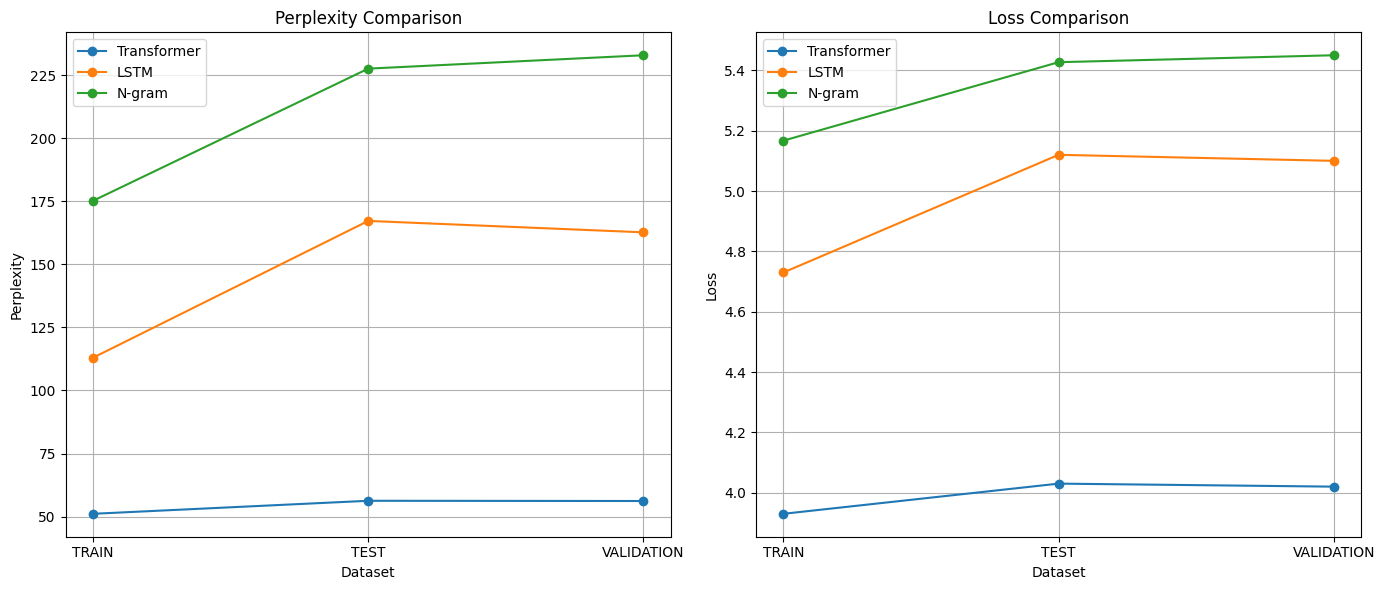

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the models
datasets = ['TRAIN', 'TEST', 'VALIDATION']
transformer_perplexity = [51.12, 56.28, 56.19]
lstm_perplexity = [113.02, 167.23, 162.70]
ngram_perplexity = [175.23, 227.60, 232.90]

transformer_loss = [3.93, 4.03, 4.02]
lstm_loss = [4.73, 5.12, 5.10]
ngram_loss = [5.167, 5.427, 5.450]

# Plot Perplexity
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(datasets, transformer_perplexity, marker='o', label='Transformer')
plt.plot(datasets, lstm_perplexity, marker='o', label='LSTM')
plt.plot(datasets, ngram_perplexity, marker='o', label='N-gram')
plt.title('Perplexity Comparison')
plt.xlabel('Dataset')
plt.ylabel('Perplexity')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(datasets, transformer_loss, marker='o', label='Transformer')
plt.plot(datasets, lstm_loss, marker='o', label='LSTM')
plt.plot(datasets, ngram_loss, marker='o', label='N-gram')
plt.title('Loss Comparison')
plt.xlabel('Dataset')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()